# Data Analysis

In [243]:
import json
import PIL
from PIL import Image, ImageDraw, ImageColor, ImageFont
import matplotlib.pyplot as plt
import requests
import cv2
import pandas as pd

## Preprocess data

In [244]:
with open("../../../datasets/coco-dataset/annotations/instances_val2017.json",'r') as f:
    data = json.load(f)

In [245]:
type(data)

dict

In [246]:
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [250]:
images_df = pd.DataFrame(data['images'])
annotation_df = pd.DataFrame(data['annotations'])
category_df = pd.DataFrame(data['categories'])

In [313]:
del annotation_df['segmentation']

In [315]:
merge1_df = pd.merge(annotation_df, images_df, how='inner',left_on="image_id", right_on="id")
del merge1_df['id_x'], merge1_df['id_y']

In [320]:
merge1_df.columns

Index(['area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'license',
       'file_name', 'coco_url', 'height', 'width', 'date_captured',
       'flickr_url'],
      dtype='object')

In [322]:
merge_final_df = pd.merge(merge1_df, category_df, how='inner', left_on='category_id', right_on='id')
del merge_final_df['id']

In [323]:
merge_final_df.head(2)

,area,iscrowd,image_id,bbox,category_id,license,file_name,coco_url,height,width,date_captured,flickr_url,supercategory,name
0,702.10575,0,289343,"[473.07, 395.93, 38.65, 28.67]",18,2,000000289343.jpg,http://images.cocodataset.org/val2017/00000028...,640,529,2013-11-15 00:35:14,http://farm5.staticflickr.com/4029/4669549715_...,animal,dog
1,27718.47630,0,61471,"[272.1, 200.23, 151.97, 279.77]",18,1,000000061471.jpg,http://images.cocodataset.org/val2017/00000006...,480,640,2013-11-15 01:18:25,http://farm1.staticflickr.com/11/12252917_d009...,animal,dog


In [331]:
merge_final_df.to_json("data/final_coco.json")

## Plot Image with object box

In [302]:
def plot_bbox(
    image_path,
    annotation,
    enable_text=False,
    color=0
):
    image = PIL.Image.open(image_path)
    draw = PIL.ImageDraw.Draw(image)
    for i,a in annotation.iterrows():
        bbox = a['bbox']
        category = a['name']
        le,up,ri,lo = bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]
        draw.rectangle([le,up,ri,lo],outline=color,width=2)
        if enable_text:
            half = (ri - le)//2
            draw.text(
                [bbox[0]+half, bbox[1]],
                category,
                fill=color
            )
#     print("image showed")
    return image

In [303]:
anno_merge_df.head(2)

,segmentation,area,iscrowd,image_id,bbox,category_id,id_x,supercategory,id_y,name
0,"[[224.24, 297.18, 228.29, 297.18, 234.91, 298....",1481.38065,0,397133,"[217.62, 240.54, 38.99, 57.75]",44,82445,kitchen,44,bottle
1,"[[292.37, 425.1, 340.6, 373.86, 347.63, 256.31...",54085.62170,0,397133,"[1.0, 240.24, 346.63, 186.76]",67,119568,furniture,67,dining table


In [327]:
indx = 10

base_path = "../../../datasets/coco-dataset"
t = "train"
img_info = images_df.loc[indx].to_dict()

with requests.get(img_info['coco_url']) as r:
    with open(f"{base_path}/{t}/{img_info['file_name']}", 'wb') as f:
        f.write(r.content)

file_name = img_info['file_name']
file_path = f"{base_path}/{t}/{file_name}"

img_id = img_info['id']
annotation = annotation_df[annotation_df['image_id'] == img_id]
anno_merge_df = pd.merge(annotation, category_df, how='inner', left_on="category_id", right_on="id")

In [328]:
image = plot_bbox(
    file_path,
    anno_merge_df,
    enable_text=True,
    color=255
)

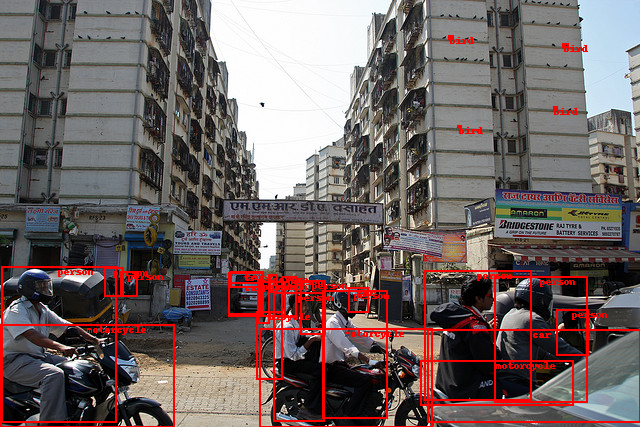

In [332]:
image

## data distribution

In [343]:
merge_final_df['name'].value_counts()

person        11004
car            1932
chair          1791
book           1161
bottle         1025
              ...  
toothbrush       57
microwave        55
scissors         36
hair drier       11
toaster           9
Name: name, Length: 80, dtype: int64

In [337]:
len(merge_final_df['name'].value_counts())

80

<AxesSubplot:>

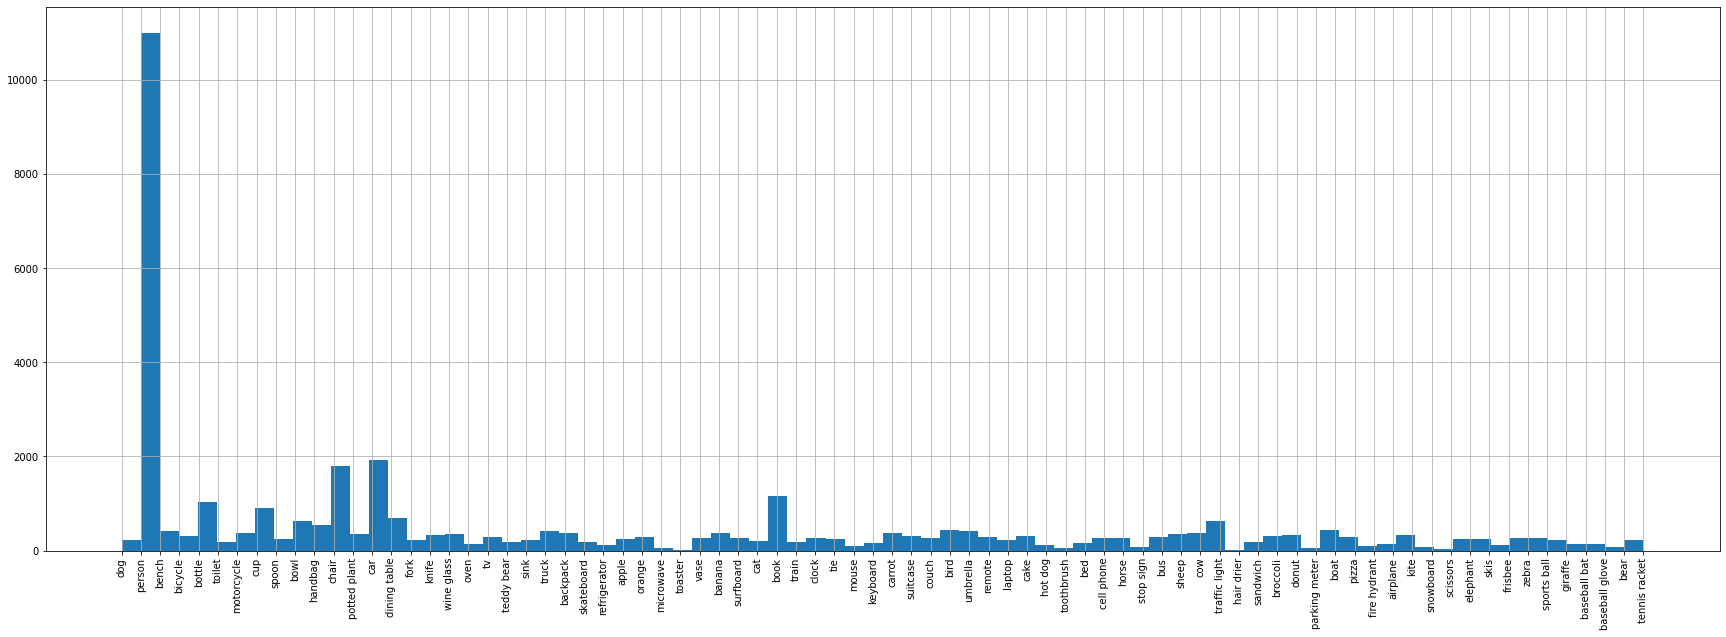

In [352]:
plt.figure(figsize=(30,10))
merge_final_df['name'].hist(xrot=90,bins=80)

In [373]:
#### we will train on
class_labels = list(merge_final_df['name'].value_counts()[1:11].to_dict().keys())

In [374]:
class_labels

['car',
 'chair',
 'book',
 'bottle',
 'cup',
 'dining table',
 'traffic light',
 'bowl',
 'handbag',
 'bird']